In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
import sklearn.linear_model
import sklearn.neural_network
import random

random.seed(42)
np.random.seed(42)


In [2]:
try:
    from ucimlrepo import fetch_ucirepo
except ImportError:
    print("Please install the ucimlrepo with pip :)")

## Data loading

In [3]:
# fetch dataset 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
  
# data (as pandas dataframes) 
X = cirrhosis_patient_survival_prediction.data.features 

data = pd.DataFrame(X)

print(data.head())

#data preparation and cleaning

data = data.replace('NaNN', np.nan)

cols = data.columns

na_per_col = {}

for col in cols:
    na_per_col[col] = data[col].isna().sum()


for key, value in na_per_col.items():
    print(key, value)

              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0         12.2    4.0  
1         10.6    3.0  
2 

Some data cleaning, removing empty value rows, disregarging binary features.

In [4]:
data.drop(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], axis=1, inplace=True)

data = data.dropna()

data.describe()

ints = ['Age', 'Copper', 'Platelets', 'Cholesterol', 'Tryglicerides']

for i in ints:
    print(i)
    data[i] = list(map(int, data[i]))

Age
Copper
Platelets
Cholesterol
Tryglicerides


## Regression A

Here we have the code for regression part A, with the following:

- Saving data on a matrix
- Scaling the data for mean of 0 and variance of 1
- Test error evolution across lambda parameter for linear regression complexity
- Effect of regularization on linear regression weights

In [5]:
# Extract attribute names
attributeNames = list(data.columns)

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(data), len(attributeNames)))
for i, col_id in enumerate(range(0,len(attributeNames))):
    X[:, i] = np.asarray(data.iloc[:, col_id])

# Compute values of N, M and C.
N = len(data.Age)
M = len(attributeNames)

scaler = StandardScaler()
Y_scaled = scaler.fit_transform(X)

### Lambda vs validation error

We will range through several values of lambda (regularization of linear regression model) to determin the best lambda and see the overall effect on the regression problem.

We will do a 1 fold validation with a total of 10 partitions. So all  model complexities are evaluated with 10 train partitions and the respective test partitions. In the end we compute the mean of the error for each lambda across all iterations of the fold.

In [ ]:
K1 = 10

# Split the data into input and target
X = Y_scaled[:,1:]
y = Y_scaled[:,0]

# Define the range of lambda values to test
lambda_range = np.logspace(-2, 3, num=100)

test_lens = []
validation_errors = []

# Loop over each cross-validation fold
for fold_index, (train_index, val_index) in enumerate(model_selection.KFold(K1).split(X)):
    print(f"Cross-validation fold: {fold_index + 1}/{K1}")

    # Split the data into training and validation sets
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    # List to store validation errors for each lambda value
    fold_errors = []

    # Train and validate the model for different values of lambda
    for l in lambda_range:
        # Train Ridge regression model
        model = sklearn.linear_model.Ridge(alpha=l).fit(X_train, y_train)
        
        # Make predictions on the validation set
        predictions = model.predict(X_val)
        
        # Calculate the Mean Squared Error (MSE) on the validation set
        mse = np.mean((predictions - y_val) ** 2)
        
        # Store the error for this value of lambda
        fold_errors.append(mse)
    
    # Store the validation errors for this fold (across different lambda values)
    validation_errors.append(fold_errors)

# Convert the list of validation errors into a numpy array
validation_errors = np.array(validation_errors)

# Calculate the mean validation error for each lambda value across all folds
mean_validation_errors = np.mean(validation_errors, axis=0)

# Find the lambda with the lowest validation error
best_lambda_index = np.argmin(mean_validation_errors)
best_lambda = lambda_range[best_lambda_index]
best_error = mean_validation_errors[best_lambda_index]

print(f"Best lambda: {best_lambda}, with validation error: {best_error}")

Cross-validation fold: 1/10
Cross-validation fold: 2/10
Cross-validation fold: 3/10
Cross-validation fold: 4/10
Cross-validation fold: 5/10
Cross-validation fold: 6/10
Cross-validation fold: 7/10
Cross-validation fold: 8/10
Cross-validation fold: 9/10
Cross-validation fold: 10/10
Best lambda: 86.97490026177834, with validation error: 0.8917669104253203


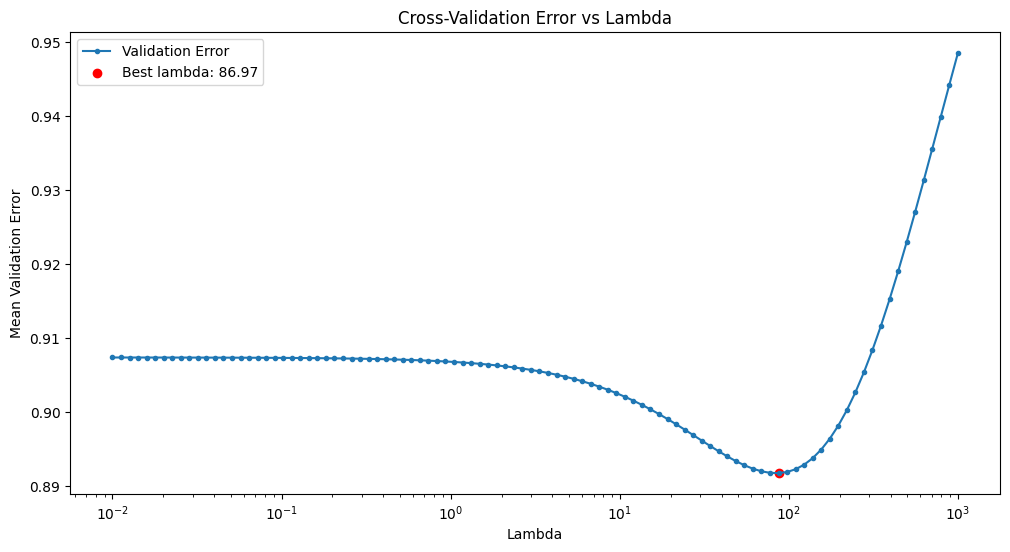

In [ ]:
# Plot the validation errors for each lambda value
f = plt.figure(figsize=(12, 6))
plt.plot(lambda_range, mean_validation_errors, marker='.', label='Validation Error')
plt.scatter(best_lambda, best_error, color='red', label=f'Best lambda: {best_lambda:.2f}')
plt.xlabel('Lambda')
plt.ylabel('Mean Validation Error')
plt.title('Cross-Validation Error vs Lambda')
plt.legend()
plt.xscale('log')
plt.savefig('cross_validation_lambda.png')
plt.show()

### Linear regression weighs

Now we will see the effect of lambda on model weighs for each of the features.

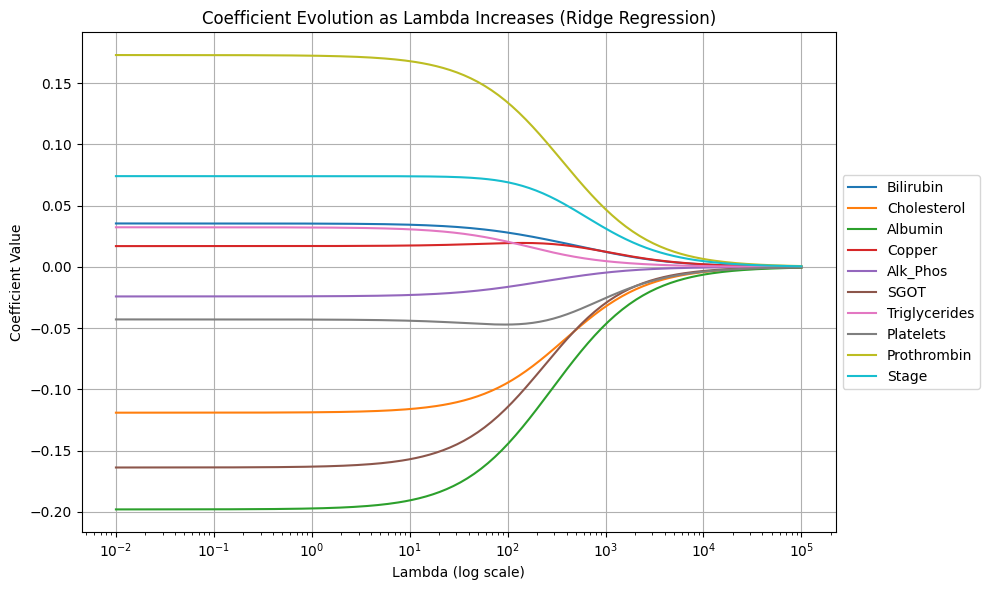

In [ ]:
# Define feature names based on your dataset
feature_names = [ 
    'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
    'Alk_Phos', 'SGOT', 'Triglycerides', 'Platelets', 
    'Prothrombin', 'Stage'
]  # Adjust according to actual feature names in your dataset

# Range of lambda (alpha) values
lambda_range = np.logspace(-2, 5, 200)  # Log scale from 1e-5 to 1e5

# Initialize list to store coefficients for each lambda
coefficients = []

# Loop over lambda values and fit the Ridge model
for lambda_value in lambda_range:
    ridge_model = sklearn.linear_model.Ridge(alpha=lambda_value)
    ridge_model.fit(X, y)
    coefficients.append(ridge_model.coef_)

# Convert the coefficients list to a numpy array for easier manipulation
coefficients = np.array(coefficients)

# Plot the coefficients as a function of lambda
plt.figure(figsize=(10, 6))
for i in range(X.shape[1]):  # Loop through all features
    plt.plot(lambda_range, coefficients[:, i], label=feature_names[i])

plt.xscale('log')  # Log scale for lambda
plt.xlabel('Lambda (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Evolution as Lambda Increases (Ridge Regression)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Puts legend outside of plot area
plt.grid(True)
plt.tight_layout()
plt.savefig('ridge_coefficients.png')
plt.show()

## Regression B

Now we will compare three models for regression: linear regression, neural network and baseline (mean of train target).

We implement a 2-fold cross validation with two *for*s, and 

In [21]:
K1 = 10
K2 = 10

k1 = 0
k2 = 0

lambda_range = list(np.arange(0.1, 200, 0.1))
hidden_range = list(range(1, 50))

linear_regression_test_errors = []
ann_test_errors = []
baseline_test_errors = []

test_lens = []

for par_index, test_index in model_selection.KFold(K1).split(X):
    print("Outter fold: {0}/{1}".format(k1 + 1, K1))

    X_par, X_test = X[par_index,:], X[test_index,:]
    y_par, y_test = y[par_index], y[test_index]


    lr_generr = []
    ann_generr = []

    train_val_fracs = []

    k2 = 0

    for train_index, val_index in model_selection.KFold(K2).split(X_par):
        print("Cross-validation fold: {0}/{1}".format(k2 + 1, K2))

        X_train, X_val = X_par[train_index,:], X_par[val_index,:]
        y_train, y_val = y_par[train_index], y_par[val_index]

        train_val_fracs.append(len(X_train)/len(X_val))

        # Train linnear regression model (ranging lambda regularization parameter)
        lr_valerr = []
        for l in lambda_range:
            mA = sklearn.linear_model.Ridge(alpha=l).fit(X_train, y_train)
            lr_preds = mA.predict(X_val)
            lr_valerr.append(np.mean((lr_preds - y_val) ** 2))
        lr_generr.append(lr_valerr)
        
        # Train ANN model
        ann_valerr = []
        for h in hidden_range:
            mB = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(h,), activation='relu', solver='adam').fit(X_train, y_train)
            ann_preds = mB.predict(X_val)
            ann_valerr.append(np.mean((ann_preds - y_val) ** 2))
        ann_generr.append(ann_valerr)

        k2 += 1

    # Compute generalization errors

    # LINNEAR REGRESSION
    lr_generr = np.dot(np.array(train_val_fracs), np.array(lr_generr))
    # Choose best model
    best_lambda = lambda_range[np.argmin(lr_generr)]
    mA = sklearn.linear_model.Ridge(alpha=best_lambda).fit(X_par, y_par)
    lr_testerr = np.mean((mA.predict(X_test) - y_test) ** 2)

    print("Best lambda: {0}".format(best_lambda))
    print("Linear regression test error: {0}".format(lr_testerr))
    linear_regression_test_errors.append(lr_testerr)

    # ANN REGRESSION
    ann_generr = np.dot(np.array(train_val_fracs), np.array(ann_generr))
    # Choose best model
    best_hidden = hidden_range[np.argmin(ann_generr)]
    mB = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(best_hidden,)).fit(X_par, y_par)
    ann_testerr = np.mean((mB.predict(X_test) - y_test) ** 2)

    print("Best hidden layer size: {0}".format(best_hidden))
    print("ANN test error: {0}".format(ann_testerr))
    ann_test_errors.append(ann_testerr)

    # BASELINE
    y_baseline = np.mean(y_par) * np.ones(len(y_test))
    baseline_testerr = np.mean((y_baseline - y_test) ** 2)
    baseline_test_errors.append(baseline_testerr)

    print(baseline_testerr)

    k1 += 1

Outter fold: 1/10
Cross-validation fold: 1/10
Cross-validation fold: 2/10
Cross-validation fold: 3/10
Cross-validation fold: 4/10
Cross-validation fold: 5/10
Cross-validation fold: 6/10
Cross-validation fold: 7/10
Cross-validation fold: 8/10
Cross-validation fold: 9/10
Cross-validation fold: 10/10
Best lambda: 56.400000000000006
Linear regression test error: 0.7762966749698427
Best hidden layer size: 34
ANN test error: 0.8486853216245429
0.8196132377582147
Outter fold: 2/10
Cross-validation fold: 1/10
Cross-validation fold: 2/10
Cross-validation fold: 3/10
Cross-validation fold: 4/10
Cross-validation fold: 5/10
Cross-validation fold: 6/10
Cross-validation fold: 7/10
Cross-validation fold: 8/10
Cross-validation fold: 9/10
Cross-validation fold: 10/10
Best lambda: 77.5
Linear regression test error: 0.6072334542200951
Best hidden layer size: 24
ANN test error: 1.5119809100238828
0.6183755969232075
Outter fold: 3/10
Cross-validation fold: 1/10
Cross-validation fold: 2/10
Cross-validation f

### Statistical analysis

In [ ]:
# Statistical analysis

print('LR vs ANN')
t, p = stats.ttest_rel(linear_regression_test_errors, ann_test_errors)
print("t-value: {0}".format(t))
print("p-value: {0}".format(p))

# Estatistical test lr vs baseline
print('LR vs Baseline')
t, p = stats.ttest_rel(linear_regression_test_errors, baseline_test_errors)
print("t-value: {0}".format(t))
print("p-value: {0}".format(p))

# Estatistical test ann vs baseline
print('ANN vs Baseline')
t, p = stats.ttest_rel(ann_test_errors, baseline_test_errors)
print("t-value: {0}".format(t))
print("p-value: {0}".format(p))

LR vs ANN
t-value: -1.6460560774801756
p-value: 0.13415971248108474
LR vs Baseline
t-value: -4.511379732486529
p-value: 0.0014648047518648684
ANN vs Baseline
t-value: 0.3270869573863689
p-value: 0.751081342324412
